## Installation required in Colab

In [1]:
# ! git clone https://github.com/shaoanlu/diffusion_policy_quadrotor.git

In [2]:
# %cd diffusion_policy_quadrotor
# %ls

In [3]:
# %%capture
# !pip3 install torch==1.13.1 torchvision==0.14.1 diffusers==0.18.2 jax==0.4.23 jaxlib==0.4.23

## Description

This notebook demonstrate using a diffusion policy controller to drive a quadrotor moving from (0, 0) to (5, 5) with random circle obstacles presented.

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import os
import torch
import yaml
import collections
from tqdm.auto import tqdm
import gdown

/home/yif/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from utils.normalizers import LinearNormalizer
from core.controllers.ee2d_diffusion_policy import EscapeEnergy2DDiffusionPolicy, build_networks_from_config, build_noise_scheduler_from_config
from core.controllers.ee2d_guidance import EscapeEnergy2DGuidanceController
# from core.controllers.quadrotor_clf_cbf_qp import QuadrotorCLFCBFController
# from core.env.planar_quadrotor import PlanarQuadrotorEnv
# from utils.visualization import visualize_quadrotor_simulation_result

/home/yif/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Load the config file

In [7]:
with open("config/config_ee2d.yaml", "r") as file:
    config = yaml.safe_load(file)

# Whether to use a finetuned model trained following tricks mentioned in
# [Fine-Tuning Image-Conditional Diffusion Models is Easier than You Think](https://arxiv.org/abs/2409.11355)
use_single_step_inference = config.get("controller").get("common").get("use_single_step_inference", False)

## Instantiate the controller

In [8]:
torch.cuda.is_available() # TODO

False

In [9]:
# clf_cbf_controller = QuadrotorCLFCBFController(config=config)
ee2d_guidance_controller = EscapeEnergy2DGuidanceController(config=config)

controller = EscapeEnergy2DDiffusionPolicy(
    model=build_networks_from_config(config),
    noise_scheduler=build_noise_scheduler_from_config(config),
    normalizer=LinearNormalizer(),
    ee2d_guidance=ee2d_guidance_controller,  # set as clf_cbf_controller to enable CLF-CBF traj refinement
    config=config,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

## Download and load pretrained weights

In [10]:
ckpts_path = "train/ckpt_ep224.ckpt"
controller.load_weights(ckpts_path)

## Run simulation

In [11]:
def inference(state, centers, rads, max_steps=20, take_only_first_action=False):
    # data preparation
    print(f"Start state: {state}")
    states = [state]  # `states` is a list containing the states over time
    obs_encode = np.hstack([centers, rads]).flatten()
    obs = {
        "state": collections.deque([state] * controller.obs_horizon, maxlen=controller.obs_horizon),
        "obs_encode": [obs_encode],
    }

    # termination params
    done = False
    step_idx = 0
    with tqdm(total=max_steps, desc="Eval") as pbar:
        while not done:
            # controller inference
            action = controller.predict_action(obs) # TODO: out of [[-1,1],[-1,1],] bounds

            # execute action_horizon steps without replanning
            print(f"Step {step_idx}")
            print(f"state: {state}, action0: {action[0]}")
            print(f"obs ", obs["state"])
            for i in range(action.shape[0]):
                state = action[i]
                # save observations and controls
                obs["state"].append(state.copy())
                states.append(state.copy())

                # update progress bar
                step_idx += 1
                pbar.update(1)
                if step_idx > max_steps:
                    done = True
                if take_only_first_action or done:
                    break
    return states

In [37]:
from dataset.escape_from_u_generator import generate_u_obstacles
np.random.seed(12)

# Env parameters
max_steps = 50

# get first observation
centers, rads = generate_u_obstacles()
start_x = np.random.uniform(centers[0][0] + rads[0][0], centers[2][0] - rads[2][0])
start_y = np.random.uniform(centers[1][1] + rads[1][1], 0.7)
state = np.array([start_x, start_y])  # [y, y_dot, z, z_dot, phi, phi_dot]

# run inference
states = inference(state, centers, rads, max_steps=max_steps, take_only_first_action=0)

Start state: [0.5401172 0.6914343]


Eval:   0%|          | 0/50 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.9764578193508486
!!!!!!!!!!!grad, [[0.83339382 4.40038826]
 [0.         0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.9898352305201376
!!!!!!!!!!!grad, [[ 0.51875439 -1.8536693 ]
 [ 0.1296886  -0.46341733]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.9440589975175291
!!!!!!!!!!!grad, [[ 0.2780953  -5.42073691]
 [ 0.18539686 -3.61382461]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!1-dist_x - dist_y, 0.8391291203430209
!!!!!!!!!!!grad, [[ 0.11141653 -6.30081456]
 [ 0.1671248  -9.45122184]]
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.675045598996616
!!!!!!!!!!!grad, [[  0.0187181   -4.49390226]
 [  0.0748724  -17.97560903]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 1
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t,

Eval:   2%|▏         | 1/50 [00:02<01:55,  2.35s/it]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.5442514118602495
!!!!!!!!!!!grad, [[-1.30362264 25.81161827]
 [-0.          0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.9491575541965545
!!!!!!!!!!!grad, [[-1.32443155 -2.65764597]
 [-0.33110789 -0.66441149]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.2579944150880463
!!!!!!!!!!!grad, [[ -1.20447373 -19.47343991]
 [ -0.80298249 -12.98229327]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 1
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.600000

Eval:  28%|██▊       | 14/50 [00:04<00:10,  3.58it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.5503477004476015
!!!!!!!!!!!grad, [[-4.36852316 -8.87942891]
 [-0.         -0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.34668410188134313
!!!!!!!!!!!grad, [[ 1.77479242 -8.79367945]
 [ 0.44369811 -2.19841986]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 1
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 2
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.600000000

Eval:  54%|█████▍    | 27/50 [00:06<00:04,  4.79it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.656931761065485
!!!!!!!!!!!grad, [[6.59129214 7.22587983]
 [0.         0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.5004180720485875
!!!!!!!!!!!grad, [[9.48756721 5.91988038]
 [2.3718918  1.4799701 ]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.26197280932303585
!!!!!!!!!!!grad, [[10.27657553  4.54429268]
 [ 6.85105035  3.02952845]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 1
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.19029828083697908
!!!!!!!!!!!grad, [[ 4.32267913  0.95884769]
 [17.29071651  3.83539075]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6

Eval: 51it [00:08,  5.77it/s]                        

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 1
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 2
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!

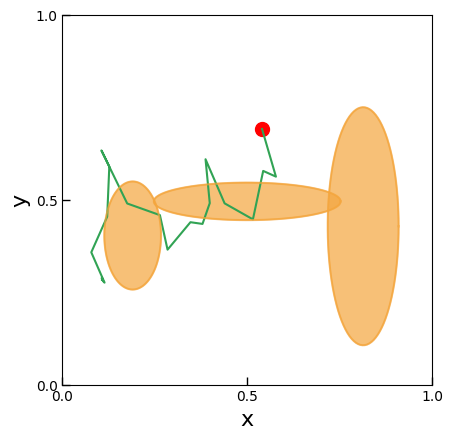

In [38]:
# Visualize the simulation result (single environment)
from dataset.escape_from_u_generator import plot
plot(states, None, centers, rads)

## Visualize Result in Batch

In [14]:
from dataset.escape_from_u_generator import plot_multiple
import joblib
import numpy as np
from matplotlib import pyplot as plt

In [15]:
# Visualize the simulation result (multiple environment)
trn_data = joblib.load("dataset_escape_from_u_2d_30000_envs.joblib")
num_envs = 10
sol_path_list = []
cost_list = []
centers_list = []
rads_list = []
for env_idx in range(num_envs):
    sol_path_list.append(trn_data["paths"][-env_idx])
    cost_list.append(trn_data["costs"][-env_idx])
    centers_list.append(trn_data["ellipse_centers"][-env_idx])
    rads_list.append(trn_data["ellipse_radii"][-env_idx])

# generate escape paths for multiple environments
generated_path_list = []
generated_cost_list = []
for env_idx in range(num_envs):
    centers, rads = centers_list[env_idx], rads_list[env_idx]
    start_x = sol_path_list[env_idx][0][0]
    start_y = sol_path_list[env_idx][0][1]
    state = np.array([start_x, start_y])  # [y, y_dot, z, z_dot, phi, phi_dot]
    path = inference(state, centers, rads, max_steps=max_steps, take_only_first_action=0)
    generated_path_list.append(path)
    generated_cost_list.append(np.max(path, axis=0)[1] - start_y)


Start state: [0.68390591 0.59808791]


Eval:   0%|          | 0/10 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.10512916347671086
!!!!!!!!!!!grad, [[ 1.79587417e-02 -6.23902144e+00]
 [ 7.18349668e-02 -2.49560858e+01]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.600000000

Eval: 11it [00:01,  7.48it/s]                       


!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
Step 0
state: [0.68390591 0.59808791], action0: [nan nan]
obs  deque([array([0.68390591, 0.59808791]), array([0.68390591, 0.59808791]), array([0.68390591, 0.59808791]), array([0.68390591, 0.59808791])], maxlen=4)
Start state: [0.42452022 0.61426271]


Eval:   0%|          | 0/10 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.8982092155127926
!!!!!!!!!!!grad, [[ 0.55394847 -8.40574382]
 [ 0.         -0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.9231861305276008
!!!!!!!!!!!grad, [[ 0.39013686 -5.83570466]
 [ 0.09753421 -1.45892617]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.9446505290238563
!!!!!!!!!!!grad, [[ 0.2528362  -3.7101107 ]
 [ 0.16855747 -2.47340713]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!1-dist_x - dist_y, 0.9626024110015581
!!!!!!!!!!!grad, [[ 0.14204651 -2.02896194]
 [ 0.21306977 -3.04344291]]
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.9770417764607077
!!!!!!!!!!!grad, [[ 0.05776778 -0.79225837]
 [ 0.23107111 -3.16903348]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t

Eval: 11it [00:01,  7.43it/s]                       


!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
Step 0
state: [0.42452022 0.61426271], action0: [nan nan]
obs  deque([array([0.42452022, 0.61426271]), array([0.42452022, 0.61426271]), array([0.42452022, 0.61426271]), array([0.42452022, 0.61426271])], maxlen=4)
Start state: [0.42400369 0.64052494]


Eval:   0%|          | 0/10 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.8907986794363392
!!!!!!!!!!!grad, [[-0.31269651 -7.27643252]
 [-0.         -0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.8660973094639498
!!!!!!!!!!!grad, [[-0.25715901 -6.45501271]
 [-0.06428975 -1.61375318]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.8388544064440946
!!!!!!!!!!!grad, [[-0.1981206  -5.31665955]
 [-0.1320804  -3.5444397 ]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!1-dist_x - dist_y, 0.8090699703767734
!!!!!!!!!!!grad, [[-0.1355813  -3.86137305]
 [-0.20337195 -5.79205958]]
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.7767440012619864
!!!!!!!!!!!grad, [[-0.0695411 -2.0891532]
 [-0.2781644 -8.3566128]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.

Eval: 11it [00:01,  8.14it/s]                       


!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!

Eval:   0%|          | 0/10 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.9976128419367057
!!!!!!!!!!!grad, [[-0.1745478   1.10603995]
 [-0.          0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.999709564487316
!!!!!!!!!!!grad, [[-0.07107314  0.25548457]
 [-0.01776828  0.06387114]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.9996665551852046
!!!!!!!!!!!grad, [[-0.00188103 -0.28039712]
 [-0.00125402 -0.18693142]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!1-dist_x - dist_y, 0.9974838140303718
!!!!!!!!!!!grad, [[ 0.03302853 -0.50160511]
 [ 0.0495428  -0.75240767]]
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.9931613410228175
!!!!!!!!!!!grad, [[ 0.03365554 -0.40813941]
 [ 0.13462216 -1.63255762]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t,

Eval: 11it [00:01,  8.11it/s]                       


!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
Step 0
state: [0.52035488 0.57535166], action0: [nan nan]
obs  deque([array([0.52035488, 0.57535166]), array([0.52035488, 0.57535166]), array([0.52035488, 0.57535166]), array([0.52035488, 0.57535166])], maxlen=4)
Start state: [0.61018222 0.66141377]


Eval:   0%|          | 0/10 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.8161968362817505
!!!!!!!!!!!grad, [[-2.68446799e-03 -1.08422436e+01]
 [-0.00000000e+00 -0.00000000e+00]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.8234911594858532
!!!!!!!!!!!grad, [[ 0.05473134 -8.49638055]
 [ 0.01368283 -2.12409514]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.8303119185847323
!!!!!!!!!!!grad, [[ 0.08370769 -6.23922468]
 [ 0.05580512 -4.15948312]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!1-dist_x - dist_y, 0.8366591135783853
!!!!!!!!!!!grad, [[ 0.08424458 -4.07077597]
 [ 0.12636687 -6.10616396]]
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.8425327444668134
!!!!!!!!!!!grad, [[ 0.05634202 -1.99103441]
 [ 0.22536807 -7.96413764]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 

Eval: 11it [00:01,  9.11it/s]                       


!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
Step 0
state: [0.61018222 0.66141377], action0: [nan nan]
obs  deque([array([0.61018222, 0.66141377]), array([0.61018222, 0.66141377]), array([0.61018222, 0.66141377]), array([0.61018222, 0.66141377])], maxlen=4)
Start state: [0.42481733 0.68970638]


Eval:   0%|          | 0/10 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.9783295494501554
!!!!!!!!!!!grad, [[-0.19859636 -4.4268972 ]
 [-0.         -0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.9718032364374775
!!!!!!!!!!!grad, [[-0.05096521 -4.09682685]
 [-0.0127413  -1.02420671]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.9636439966583772
!!!!!!!!!!!grad, [[ 0.04271001 -3.48910195]
 [ 0.02847334 -2.32606797]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!1-dist_x - dist_y, 0.953851830112855
!!!!!!!!!!!grad, [[ 0.08242928 -2.60372252]
 [ 0.12364392 -3.90558377]]
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.9424267368009096
!!!!!!!!!!!grad, [[ 0.06819261 -1.44068853]
 [ 0.27277044 -5.76275412]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t,

Eval: 11it [00:01,  8.22it/s]                       


!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!

Eval:   0%|          | 0/10 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.15654897772597254
!!!!!!!!!!!grad, [[  0.02355895 -14.34489873]
 [  0.01570597  -9.56326582]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!1-dist_x - dist_y, 0.6637964020390439
!!!!!!!!!!!grad, [[ 0.36289446 -5.79112581]
 [ 0.54434169 -8.68668871]]
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.859312822388351
!!!!!!!!!!!grad, [[ 0.35504148 -1.0094929 ]
 [ 1.42016592 -4.03797159]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.600000

Eval: 11it [00:01,  9.25it/s]                       


!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
Step 0


Eval:   0%|          | 0/10 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.5248768306897027
!!!!!!!!!!!grad, [[ -0.66045917 -15.96656395]
 [ -0.          -0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.5949626592793459
!!!!!!!!!!!grad, [[ -0.3240548  -11.87038853]
 [ -0.0810137   -2.96759713]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.6571624994890475
!!!!!!!!!!!grad, [[-0.0898067  -8.22564443]
 [-0.05987113 -5.48376295]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!1-dist_x - dist_y, 0.7114763513188068
!!!!!!!!!!!grad, [[ 0.04228513 -5.03233164]
 [ 0.0634277  -7.54849746]]
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.7579042147686245
!!!!!!!!!!!grad, [[ 0.0722207  -2.29045016]
 [ 0.28888281 -9.16180065]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!

Eval: 11it [00:01,  8.47it/s]                       


!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
Step 0
state: [0.62368274 0.67006459], action0: [nan nan]
obs  deque([array([0.62368274, 0.67006459]), array([0.62368274, 0.67006459]), array([0.62368274, 0.67006459]), array([0.62368274, 0.67006459])], maxlen=4)
Start state: [0.63373544 0.67485725]


Eval:   0%|          | 0/10 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.9055910053342454
!!!!!!!!!!!grad, [[ 0.13344979 -6.51103894]
 [ 0.         -0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.9302365917804714
!!!!!!!!!!!grad, [[ 0.06034065 -4.48503244]
 [ 0.01508516 -1.12125811]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.9510503922549428
!!!!!!!!!!!grad, [[ 0.01044111 -2.8209253 ]
 [ 0.00696074 -1.88061686]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!1-dist_x - dist_y, 0.9680324067576602
!!!!!!!!!!!grad, [[-0.01624885 -1.51871751]
 [-0.02437327 -2.27807626]]
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.9811826352886225
!!!!!!!!!!!grad, [[-0.01972922 -0.57840908]
 [-0.07891687 -2.3136363 ]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t

Eval: 11it [00:01,  7.77it/s]                       


!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
Step 0


Eval:   0%|          | 0/10 [00:00<?, ?it/s]

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!1-dist_x - dist_y, 0.9818680542263946
!!!!!!!!!!!grad, [[-0.03371471 -3.55114569]
 [-0.         -0.        ]]
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!1-dist_x - dist_y, 0.946419049009083
!!!!!!!!!!!grad, [[ 3.75318269e-03 -4.88720345e+00]
 [ 9.38295673e-04 -1.22180086e+00]]
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!1-dist_x - dist_y, 0.8921139116579451
!!!!!!!!!!!grad, [[ 0.0258586  -5.20011777]
 [ 0.01723906 -3.46674518]]
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!1-dist_x - dist_y, 0.8189526421729808
!!!!!!!!!!!grad, [[ 0.03260154 -4.48988863]
 [ 0.04890231 -6.73483294]]
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!1-dist_x - dist_y, 0.72693524055419
!!!!!!!!!!!grad, [[  0.02398201  -2.75651604]
 [  0.09592802 -11.02606416]]
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t,

Eval: 11it [00:01,  8.19it/s]                       

!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!k, 0
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
!!!!!!!!!!!t, 0.0
!!!!!!!!!!!t, 0.2
!!!!!!!!!!!t, 0.4
!!!!!!!!!!!t, 0.6000000000000001
!!!!!!!!!!!t, 0.8
Step 0
state: [0.3900345  0.61828308], action0: [nan nan]
obs  deque([array([0.3900345 , 0.61828308]), array([0.3900345 , 0.61828308]), array([0.3900345 , 0.61828308]), array([0.3900345 , 0.61828308])], maxlen=4)


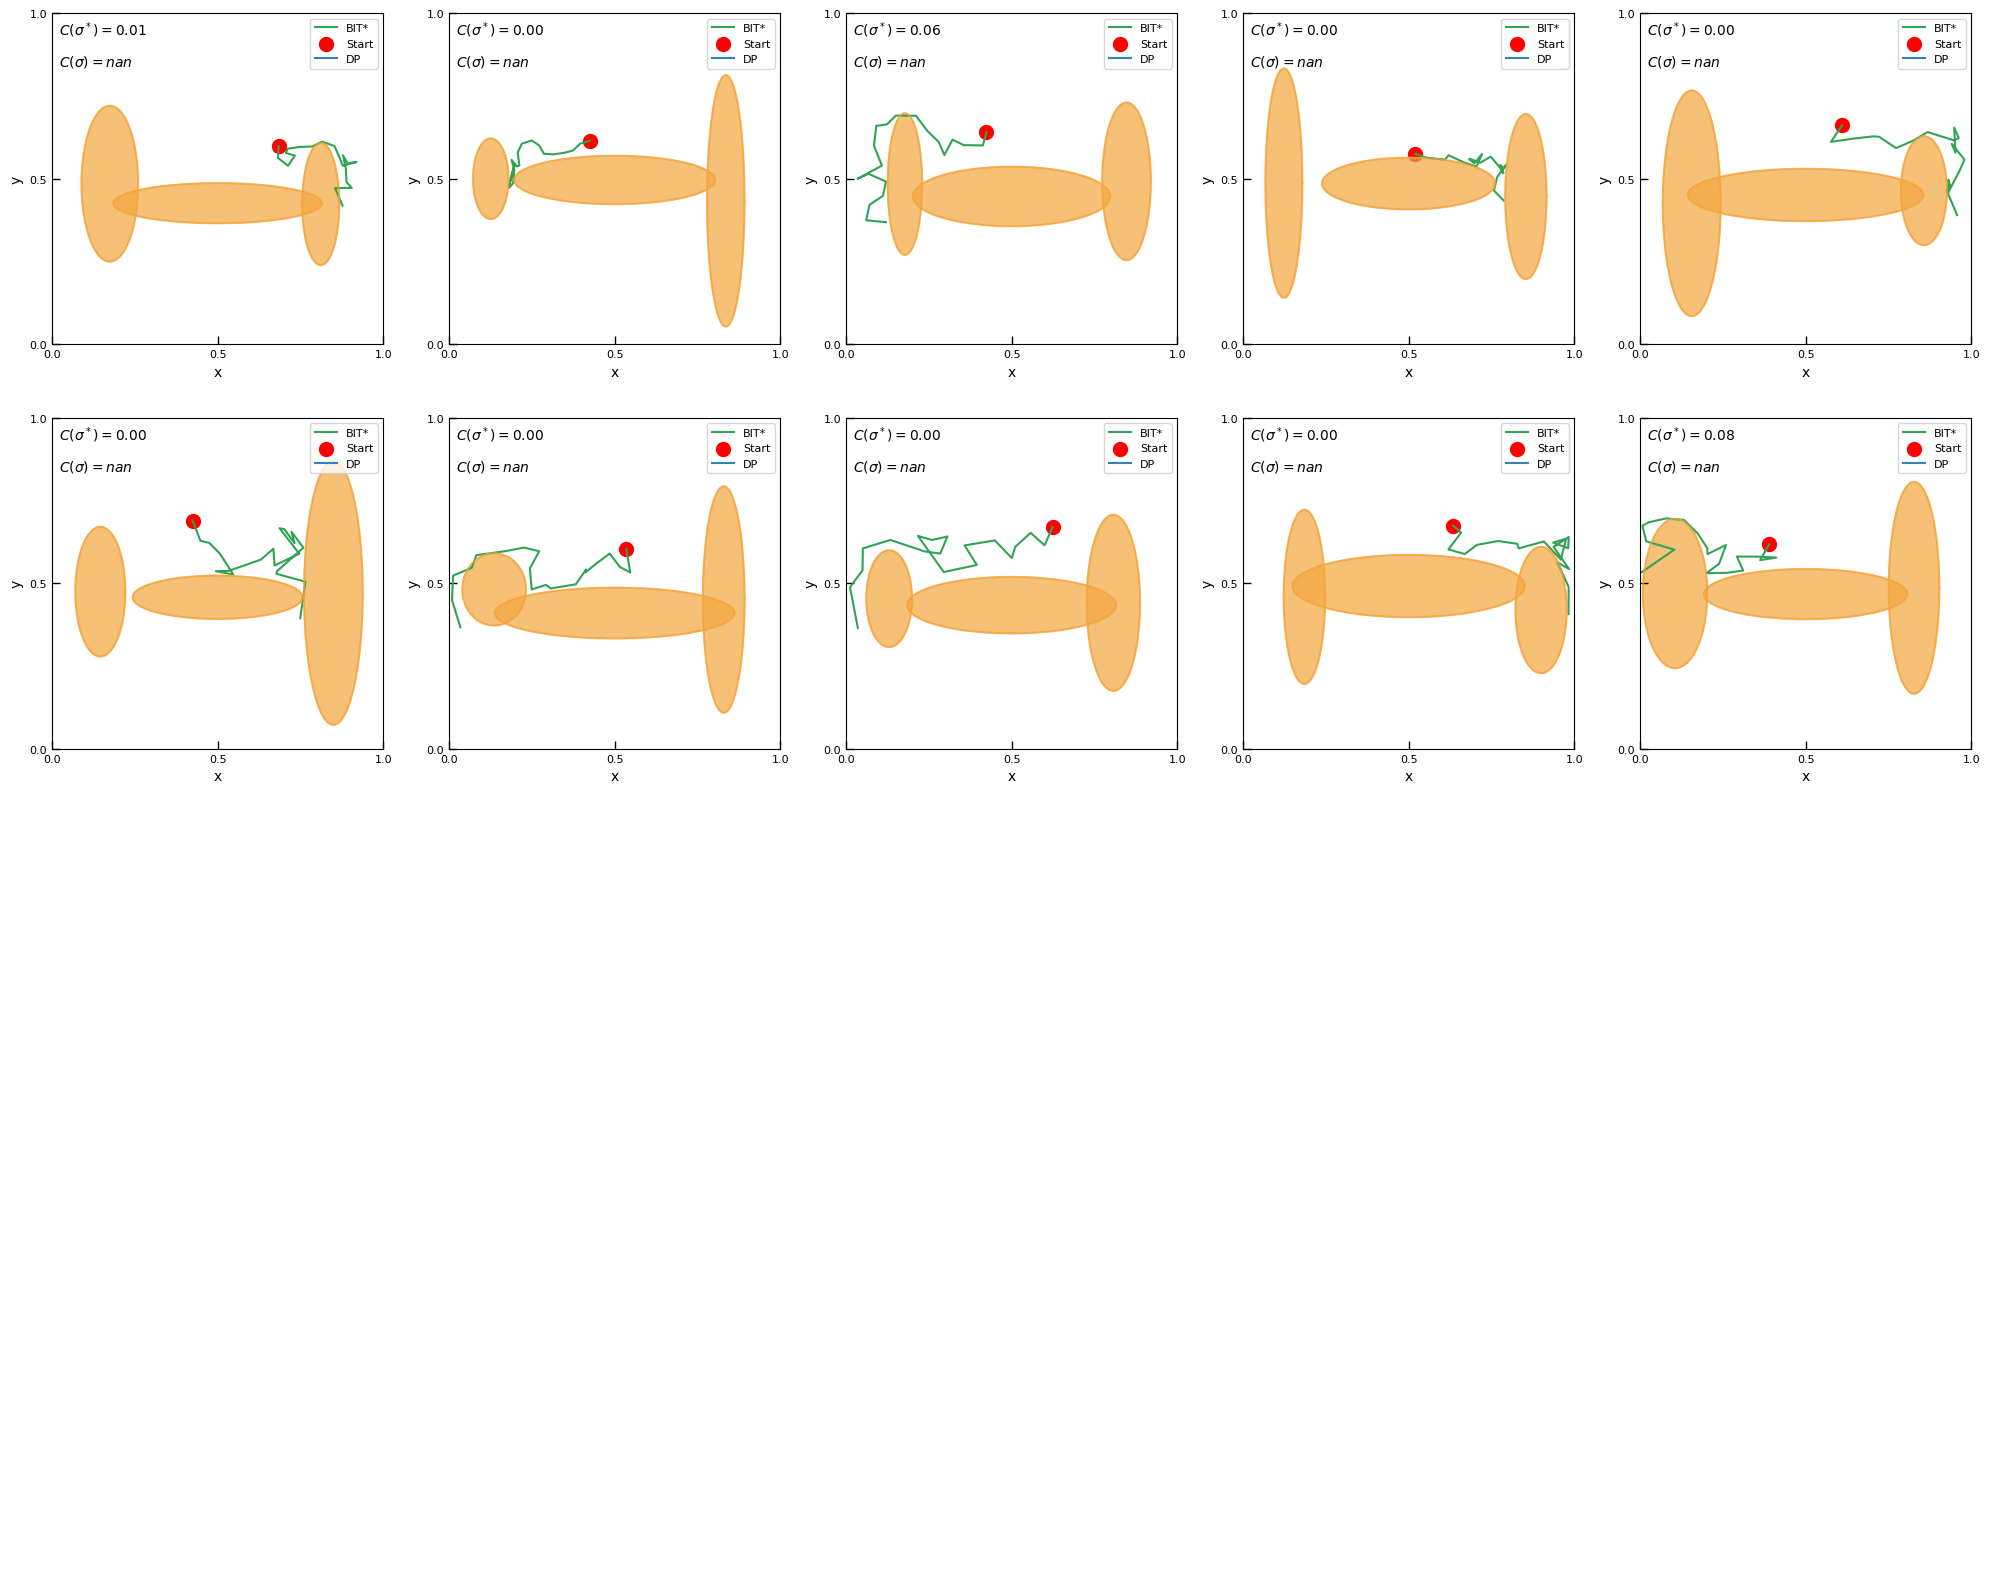

In [16]:
plot_multiple(sol_path_list, cost_list, centers_list, rads_list, generated_path_list, generated_cost_list)
